# Project Notebook

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
import nltk

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /home/yann/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/yann/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/yann/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/yann/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## Data exploration

### Cleaning data algorithm

In [2]:
from nltk.corpus import stopwords
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
import re, string

def lemmatize_sentence(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmatized_sentence = []
    for word, tag in pos_tag(tokens):
        if tag.startswith('NN'):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'
        lemmatized_sentence.append(lemmatizer.lemmatize(word, pos))
    return lemmatized_sentence

def clean_single(tweet, stop_words = stopwords.words('english'), numbers=True):

    cleaned_tokens = []
    # Removing links
    tweet = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', tweet)
    # Removing @
    tweet = re.sub("(@[A-Za-z0-9_]+)","", tweet)
        
    # Removing currencies
    tweet = re.sub(r'\$\w*', '', tweet)
    
    tokens = word_tokenize(tweet)
    
    for token, tag in pos_tag(tokens):
                
        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'

        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)

        if len(token) > 0 and token not in string.punctuation and token.lower() not in stop_words:
            cleaned_tokens.append(token.lower())
            
            # remove tokens containing numbers
    if numbers:
        numbers = [str(i) for i in range(10)]
        kill_list = []
        for number in numbers:
            kill_list = kill_list + [w for w in cleaned_tokens if number in w]
        # removing selected tokens
        cleaned_tokens = [w for w in cleaned_tokens if not w in kill_list]
        
        # merge tokens
        merged = ' '
        merged = merged.join(cleaned_tokens)
        
    return merged

def clean(array):
    for i, phrase in enumerate(array):
        array[i] = clean_single(phrase)
    return array

### Opening dataset files, cleaning and saving

In [3]:
# df_raw_sentiment = pd.read_csv('data/training.1600000.processed.noemoticon.csv', 
#                           engine='python', 
#                           header=None, 
#                           names=['score', 'tweet_id', 'date', '?', 'account', 'text'])
# df_sentiment = df_raw_sentiment[['score', 'text']]


# classification = np.ones(len(df_sentiment), dtype=np.int)
# classification[df_sentiment['score']==0] = -1

# df_sentiment.insert(loc=2, column='classification', value=classification)
# df_sentiment = df_sentiment[['classification', 'text']]

# sentiment_classification = df_sentiment.classification.values
# sentiment_text = clean(df_sentiment.text.values)

# print(sentiment_classification.shape, sentiment_text.shape)

# temp = pd.DataFrame({'text':sentiment_text,'classification':sentiment_classification})
# temp.to_csv('data/sentiment_cleaned.csv', index=False)

# df_raw_airlines = pd.read_csv('data/Tweets.csv', engine='python')
# df_airlines = df_raw_airlines[['airline_sentiment', 'text']]

# classification = np.zeros(len(df_airlines), dtype=np.int)
# classification[df_airlines['airline_sentiment']=='negative'] = -1
# classification[df_airlines['airline_sentiment']=='neutral'] = 0
# classification[df_airlines['airline_sentiment']=='positive'] = 1

# df_airlines.insert(loc=2, column='classification', value=classification)
# df_airlines = df_airlines[['classification', 'text']]

# airlines_classification = df_airlines.classification.values
# airlines_text = clean(df_airlines.text.values)

# print(airlines_classification.shape, airlines_text.shape)

# temp = pd.DataFrame({'text':airlines_text,'classification':airlines_classification})
# temp.to_csv('data/airlines_cleaned.csv', index=False)

#### Opening cleaned data

In [4]:
df_airlines = pd.read_csv('data/airlines_cleaned.csv').dropna()
df_airlines.head()

,text,classification
0,say,0
1,plus 've add commercial experience ... tacky,1
2,n't today ... must mean need take another trip,0
3,'s really aggressive blast obnoxious `` entert...,-1
4,'s really big bad thing,-1


In [5]:
df_sentiment = pd.read_csv('data/sentiment_cleaned.csv').dropna()
df_sentiment.head()

,text,classification
0,awww 's bummer shoulda get david carr third day,-1
1,upset ca n't update facebook texting ... might...,-1
2,dive many time ball managed save rest go bound,-1
3,whole body feel itchy like fire,-1
4,'s behave 'm mad ca n't see,-1


### Visualisation

#### Sentiment repartition over the datasets

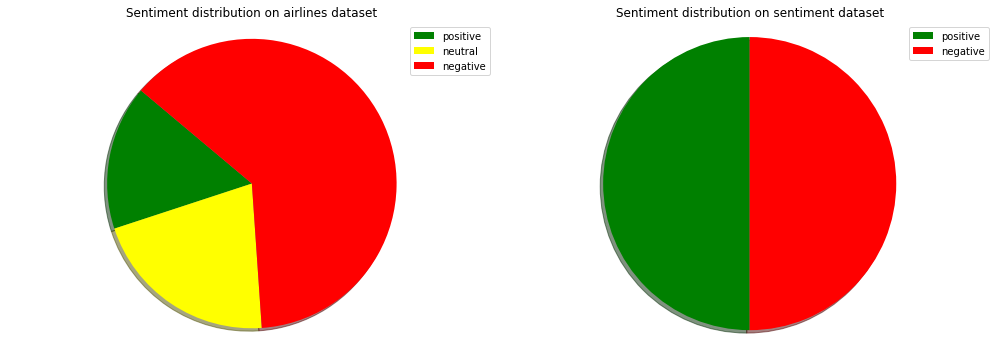

In [6]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
labels = ['positive', 'neutral', 'negative']
sizes = [np.sum(df_airlines.classification==1), np.sum(df_airlines.classification==0), np.sum(df_airlines.classification==-1)]
colors = ['green', 'yellow', 'red']
patches, texts = plt.pie(sizes, colors=colors, shadow=True, startangle=140)
plt.legend(patches, labels, loc="best")
plt.axis('equal')
plt.tight_layout()
plt.title('Sentiment distribution on airlines dataset')

plt.subplot(1,2,2)
labels = ['positive', 'negative']
sizes = [np.sum(df_sentiment.classification==1), np.sum(df_sentiment.classification==-1)]
colors = ['green', 'red']
patches, texts = plt.pie(sizes, colors=colors, shadow=True, startangle=90)
plt.legend(patches, labels, loc="best")
plt.axis('equal')
plt.tight_layout()
plt.title('Sentiment distribution on sentiment dataset')
plt.savefig('figures/pie_charts_sentiment_distribution.png')
plt.show()

#### Wordclouds for the airlines dataset

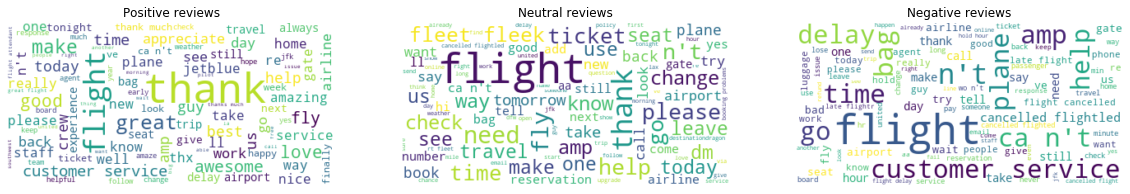

In [7]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

pos_text = " ".join(df_airlines[df_airlines.classification==1].text.values)
neg_text = " ".join(df_airlines[df_airlines.classification==-1].text.values)
neu_text = " ".join(df_airlines[df_airlines.classification==0].text.values)

wordcloud_pos = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(pos_text)
wordcloud_neg = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(neg_text)
wordcloud_neu = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(neu_text)

plt.figure(figsize=(20, 20))
plt.subplot(1,3,1)
plt.imshow(wordcloud_pos, interpolation="bilinear")
plt.axis("off")
plt.title('Positive reviews')
plt.subplot(1,3,2)
plt.imshow(wordcloud_neu, interpolation="bilinear")
plt.axis("off")
plt.title('Neutral reviews')
plt.subplot(1,3,3)
plt.imshow(wordcloud_neg, interpolation="bilinear")
plt.axis("off")
plt.title('Negative reviews')
plt.savefig('figures/airline_wordclouds.png')
plt.show()

#### Wordclouds for the sentiment dataset

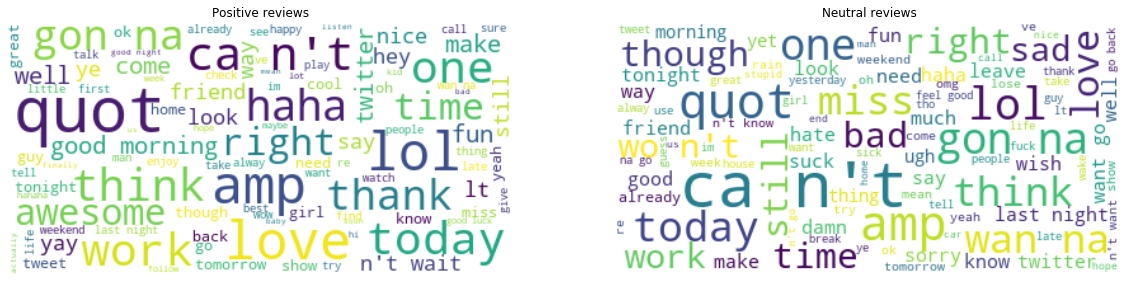

In [8]:
pos_text = " ".join(df_sentiment[df_sentiment.classification==1].text.values)
neg_text = " ".join(df_sentiment[df_sentiment.classification==-1].text.values)

wordcloud_pos = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(pos_text)
wordcloud_neg = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(neg_text)

plt.figure(figsize=(20, 20))
plt.subplot(1,2,1)
plt.imshow(wordcloud_pos, interpolation="bilinear")
plt.axis("off")
plt.title('Positive reviews')
plt.subplot(1,2,2)
plt.imshow(wordcloud_neg, interpolation="bilinear")
plt.axis("off")
plt.title('Neutral reviews')
plt.savefig('figures/sentiment_wordclouds.png')
plt.show()

## Feature extraction (TF-IDF)

### Vectorizer without bag of words

### Vectorizer with bag of words

## Classification

### Naive Bayes

### SVM

### Fully connected network

### LSTM network